# Exploratory Data Analysis of Drillhole and Surface Copper Assay Datasets

# Part 1 — Dataset Overview & Basic Checks

## 1. Project Overview & Dataset Description
### Project Overview
This notebook presents an exploratory data analysis (EDA) of four geoscientific datasets from Western Australia, supporting mineral exploration efforts. The datasets include original laboratory copper assay results and deep-learning-based imputed values for both drillhole and surface samples.

**Objective:**  
To compare the original and imputed datasets, characterize their spatial and statistical properties, identify data quality issues, and lay the foundation for further geostatistical and visualization work.

### Dataset Description

- **Cu_ppm_Orig_DH_SOWETO:** Original copper assays for drillhole samples
- **Cu_ppm_DL_DH_SOWETO:** Deep-learning imputed copper values for drillhole samples (imputed where Cu was not originally analyzed)
- **Cu_ppm_Orig_S_SOWETO:** Original copper assays for surface samples
- **Cu_ppm_DL_S_SOWETO:** Deep-learning imputed copper values for surface samples

Each dataset includes:
- A unique sample identifier (`SAMPLEID`)
- Spatial coordinates (latitude/longitude)
- Sample type and (for drillholes) depth intervals
- Copper concentration in ppm (`Cu_ppm`)

## 2. Dataset Import & Structure Overview

In [1]:
# Setup & load
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
import numpy as np

# Define paths
project_root = Path.cwd().parent
zip_path     = project_root / "data" / "csv_datasets.zip"
extract_dir  = Path.cwd() / "tmp_csv"
PART1_DIR    = Path("../reports/task1/part1")
IMPORT_DIR   = PART1_DIR / "dataset_import"

# Ensure folders
extract_dir.mkdir(exist_ok=True, parents=True)
IMPORT_DIR.mkdir(exist_ok=True, parents=True)

# Extract CSV files
with ZipFile(zip_path) as zf:
    zf.extractall(extract_dir)

print("Extracted files:")
for p in sorted(extract_dir.glob("*.csv")):
    print(" -", p.name)

# Load datasets
df_dh_orig   = pd.read_csv(extract_dir / "Cu_ppm_Orig_DH_SOWETO.csv")
df_dh_dl     = pd.read_csv(extract_dir / "Cu_ppm_DL_DH_SOWETO.csv")
df_surf_orig = pd.read_csv(extract_dir / "Cu_ppm_Orig_S_SOWETO.csv")
df_surf_dl   = pd.read_csv(extract_dir / "Cu_ppm_DL_S_SOWETO.csv")

datasets = {
    "Drillhole Original": df_dh_orig,
    "Drillhole DNN":      df_dh_dl,
    "Surface Original":   df_surf_orig,
    "Surface DNN":        df_surf_dl,
}

# Quick preview (first 2 rows)
for name, df in datasets.items():
    print(f"\n{name} — shape: {df.shape[0]} rows × {df.shape[1]} cols")
    display(df.head(2))


Extracted files:
 - Cu_ppm_DL_DH_SOWETO.csv
 - Cu_ppm_DL_S_SOWETO.csv
 - Cu_ppm_Orig_DH_SOWETO.csv
 - Cu_ppm_Orig_S_SOWETO.csv

Drillhole Original — shape: 6429144 rows × 9 cols


,SAMPLEID,LATITUDE,LONGITUDE,SAMPLETYPE,COLLARID,FROMDEPTH,TODEPTH,Cu_ppm,SPURIOUS
0,11226292,-27.931236,116.04225,DRILLRC,554128,56.0,60.0,32.0,0
1,11226293,-27.931236,116.04225,DRILLRC,554128,60.0,64.0,83.0,0



Drillhole DNN — shape: 920576 rows × 8 cols


,SAMPLEID,LATITUDE,LONGITUDE,SAMPLETYPE,COLLARID,FROMDEPTH,TODEPTH,Cu_ppm
0,38013318,-33.359524,121.86429,DRILLSONIC,1646815,26.0,33.5,18.932
1,38013319,-33.356274,121.87158,DRILLSONIC,1646816,23.0,27.0,21.117



Surface Original — shape: 993385 rows × 6 cols


,SAMPLEID,DLAT,DLONG,SAMPLETYPE,Cu_ppm,SPURIOUS
0,7597658,-30.864110,121.117130,SHALL,40.9,0
1,7597659,-30.864086,121.115456,SHALL,45.5,0



Surface DNN — shape: 545382 rows × 5 cols


,SAMPLEID,DLAT,DLONG,SAMPLETYPE,Cu_ppm
0,8229412,-30.599585,120.88167,SOIL,71.249
1,8229413,-30.599464,120.88206,SOIL,80.444


In [2]:
# Structure summary & export
def structure_summary_row(name: str, df: pd.DataFrame) -> dict:
    return {
        "Dataset": name,
        "Rows": df.shape[0],
        "Columns": df.shape[1],
        "Column Names": ", ".join(df.columns.astype(str)),
        "Dtypes": ", ".join([f"{c}:{str(t)}" for c, t in df.dtypes.items()]),
    }

structure_df = pd.DataFrame(
    [structure_summary_row(name, df) for name, df in datasets.items()]
)

out_path = IMPORT_DIR / "structure_summary.csv"
structure_df.to_csv(out_path, index=False)
print(f"Dataset structure summary saved to: {out_path}")

structure_df

Dataset structure summary saved to: ..\reports\task1\part1\dataset_import\structure_summary.csv


,Dataset,Rows,Columns,Column Names,Dtypes
0,Drillhole Original,6429144,9,"SAMPLEID, LATITUDE, LONGITUDE, SAMPLETYPE, COL...","SAMPLEID:int64, LATITUDE:float64, LONGITUDE:fl..."
1,Drillhole DNN,920576,8,"SAMPLEID, LATITUDE, LONGITUDE, SAMPLETYPE, COL...","SAMPLEID:int64, LATITUDE:float64, LONGITUDE:fl..."
2,Surface Original,993385,6,"SAMPLEID, DLAT, DLONG, SAMPLETYPE, Cu_ppm, SPU...","SAMPLEID:int64, DLAT:float64, DLONG:float64, S..."
3,Surface DNN,545382,5,"SAMPLEID, DLAT, DLONG, SAMPLETYPE, Cu_ppm","SAMPLEID:int64, DLAT:float64, DLONG:float64, S..."


**Goal**:
Check dataset size and preview the schema.

**Interpretation**:
We confirmed the column structures are as expected, and see that each dataset contain millions of records.

## 3. Basic Dataset Info

In [3]:
# Output dir 
BASIC_DIR  = PART1_DIR / "basic_info"
BASIC_DIR.mkdir(parents=True, exist_ok=True)

### 3.1 Missing & Invalid Value Check (Cu_ppm <= 0)

**Goal**:
Identify and quantify missing or invalid values, especially in the Cu_ppm field. In these datasets, missing values are encoded with extreme placeholders (e.g., -9999900, -9999999, -298514).

In [4]:
def invalid_summary_row(name: str, df: pd.DataFrame) -> dict:
    s = pd.to_numeric(df["Cu_ppm"], errors="coerce")
    total = len(s)
    n_nonpos = (s <= 0).sum()
    return {
        "Dataset": name,
        "Total Rows": total,
        "<=0 Count": int(n_nonpos),
        "<=0 %": round(100.0 * n_nonpos / total, 2) if total else 0.0,
        "Min Cu_ppm": float(s.min()) if total else float("nan"),
        "Max Cu_ppm": float(s.max()) if total else float("nan"),
    }

invalid_rows = [
    invalid_summary_row("Drillhole Original", df_dh_orig),
    invalid_summary_row("Drillhole DNN",      df_dh_dl),
    invalid_summary_row("Surface Original",   df_surf_orig),
    invalid_summary_row("Surface DNN",        df_surf_dl),
]
invalid_df = pd.DataFrame(invalid_rows)
invalid_fp = BASIC_DIR / "invalid_values.csv"
invalid_df.to_csv(invalid_fp, index=False)
display(invalid_df)
print(f"Saved: {invalid_fp}")

,Dataset,Total Rows,<=0 Count,<=0 %,Min Cu_ppm,Max Cu_ppm
0,Drillhole Original,6429144,3962111,61.63,-9989990.000,1.300000e+09
1,Drillhole DNN,920576,0,0.00,0.002,5.635899e+06
2,Surface Original,993385,12038,1.21,-290514.000,1.000000e+06
3,Surface DNN,545382,0,0.00,0.001,1.971284e+06


Saved: ..\reports\task1\part1\basic_info\invalid_values.csv


**Interpretation**:
Drillhole original data contains a large number of missing or invalid Cu_ppm entries, while the DNN-imputed datasets are fully populated with positive values.

### 3.2 Valid Data Filtering

**Goal**:
For all statistical analysis, we exclude samples with missing, negative, or extreme (negative) Cu_ppm values.

In [5]:


def valid_mask(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    s = s.copy()
    
    return (s >= 1e-5) & (s <= 346000)


def select_valid(df, col="Cu_ppm"):
    s = pd.to_numeric(df[col], errors="coerce").copy()
    mask = (s >= 1e-5) & (s <= 346000)
    out = df.loc[mask].copy()
    out[col] = s.loc[mask].values  
    return out

df_dh_orig_valid   = df_dh_orig[valid_mask(df_dh_orig["Cu_ppm"])].copy()
df_dh_dl_valid     = df_dh_dl[valid_mask(df_dh_dl["Cu_ppm"])].copy()
df_surf_orig_valid = df_surf_orig[valid_mask(df_surf_orig["Cu_ppm"])].copy()
df_surf_dl_valid   = df_surf_dl[valid_mask(df_surf_dl["Cu_ppm"])].copy()

df_dh_orig_valid   = select_valid(df_dh_orig)
df_dh_dl_valid     = select_valid(df_dh_dl)
df_surf_orig_valid = select_valid(df_surf_orig)
df_surf_dl_valid   = select_valid(df_surf_dl)

keep_df = pd.DataFrame([
    {"Dataset": "Drillhole Original", "Before": len(df_dh_orig),   "After": len(df_dh_orig_valid)},
    {"Dataset": "Drillhole DNN",      "Before": len(df_dh_dl),     "After": len(df_dh_dl_valid)},
    {"Dataset": "Surface Original",   "Before": len(df_surf_orig), "After": len(df_surf_orig_valid)},
    {"Dataset": "Surface DNN",        "Before": len(df_surf_dl),   "After": len(df_surf_dl_valid)},
])
keep_df["KeepRatio(%)"]    = (keep_df["After"] / keep_df["Before"] * 100).round(2)
keep_df["DroppedRatio(%)"] = (100 - keep_df["KeepRatio(%)"]).round(2)

keep_fp = BASIC_DIR / "valid_counts.csv"
keep_df.to_csv(keep_fp, index=False)
display(keep_df)
print(f"Saved: {keep_fp}")

,Dataset,Before,After,KeepRatio(%),DroppedRatio(%)
0,Drillhole Original,6429144,2466130,38.36,61.64
1,Drillhole DNN,920576,920225,99.96,0.04
2,Surface Original,993385,981318,98.79,1.21
3,Surface DNN,545382,544886,99.91,0.09


Saved: ..\reports\task1\part1\basic_info\valid_counts.csv


**Interpretation**:
Filtering removes placeholder and extreme values. Drillhole original data is particularly sparse after filtering, highlighting the importance of imputation.

### 3.3 SPURIOUS field (Original datasets)

In [6]:
spurious_frames = []
for name, df in [("Drillhole Original", df_dh_orig), ("Surface Original", df_surf_orig)]:
    if "SPURIOUS" in df.columns:
        vc = df["SPURIOUS"].value_counts(dropna=True)  # do not show NaN bucket
        tmp = vc.rename_axis("SPURIOUS").reset_index(name="Count")
        tmp["Dataset"] = name
        tmp["Ratio(%)"] = (tmp["Count"] / len(df) * 100).round(2)
        spurious_frames.append(tmp)

if spurious_frames:
    spurious_df = pd.concat(spurious_frames, ignore_index=True)[["Dataset","SPURIOUS","Count","Ratio(%)"]]
    sp_fp = BASIC_DIR / "spurious_distribution.csv"
    spurious_df.to_csv(sp_fp, index=False)
    display(spurious_df)
    print(f"Saved: {sp_fp}")
else:
    print("No SPURIOUS column found in original datasets.")

,Dataset,SPURIOUS,Count,Ratio(%)
0,Drillhole Original,0,6161172,95.83
1,Drillhole Original,1,208820,3.25
2,Drillhole Original,2,59152,0.92
3,Surface Original,0,993270,99.99
4,Surface Original,2,63,0.01
5,Surface Original,1,52,0.01


Saved: ..\reports\task1\part1\basic_info\spurious_distribution.csv


**Note**
The SPURIOUS column contains values 0, 1, and 2, but their exact meanings are unclear and should be confirmed with the client. Understanding whether these values indicate valid samples or different types of suspicious/anomalous records is important because it will directly influence the data cleaning approach.

## 4. Statistical Summary of Valid Copper Assays

**Goal**:
Summarize and compare copper concentrations in original and DNN-imputed datasets.

In [7]:
# Output dir
STATS_DIR   = PART1_DIR / "statistics"
STATS_DIR.mkdir(parents=True, exist_ok=True)

In [8]:
def get_statistics(name: str, series: pd.Series) -> dict:
    """Return descriptive statistics for a numeric pandas Series."""
    s = pd.to_numeric(series, errors="coerce").dropna()
    return {
        "Dataset": name,
        "Count": s.count(),
        "Mean": s.mean(),
        "Median": s.median(),
        "Std": s.std(),
        "Variance": s.var(),
        "Min": s.min(),
        "Max": s.max(),
        "Q05": s.quantile(0.05),
        "Q25": s.quantile(0.25),
        "Q75": s.quantile(0.75),
        "Q95": s.quantile(0.95),
        "IQR": s.quantile(0.75) - s.quantile(0.25),
        "Skewness": s.skew(),
        "Kurtosis": s.kurt()
    }

# Build summaries for valid datasets only
stats_summary = []
for label, df in [
    ("Drillhole Original", df_dh_orig_valid), 
    ("Drillhole DNN",      df_dh_dl_valid),
    ("Surface Original",   df_surf_orig_valid), 
    ("Surface DNN",        df_surf_dl_valid)
]:
    stats_summary.append(get_statistics(label, df["Cu_ppm"]))

# DataFrame + rounding
stats_df = pd.DataFrame(stats_summary)
num_cols = stats_df.select_dtypes(include=[np.number]).columns
stats_df[num_cols] = stats_df[num_cols].round(4)

# Save
out_file = STATS_DIR / "copper_statistics.csv"
stats_df.to_csv(out_file, index=False)
display(stats_df)
print(f"Saved: {out_file}")

,Dataset,Count,Mean,Median,Std,Variance,Min,Max,Q05,Q25,Q75,Q95,IQR,Skewness,Kurtosis
0,Drillhole Original,2466130,298.8695,50.000,4367.8168,1.907782e+07,0.0001,345300.00,5.000,20.000,120.000,708.0000,100.000,52.7572,3223.5964
1,Drillhole DNN,920225,68.2946,28.829,1990.3266,3.961400e+06,0.0020,343866.10,7.162,12.391,67.068,129.6138,54.677,130.6248,18273.2190
2,Surface Original,981318,51.6217,21.000,1210.5326,1.465389e+06,0.0001,331446.00,0.510,6.300,45.000,99.0000,38.700,142.1744,26627.7050
3,Surface DNN,544886,89.7682,21.107,2677.1112,7.166924e+06,0.0010,342353.94,1.558,12.792,28.520,59.9265,15.728,54.8821,3438.0633


Saved: ..\reports\task1\part1\statistics\copper_statistics.csv


**Interpretation**:

After filtering out placeholder values and extreme outlier, the copper concentration in both original and DNN-imputed datasets falls within a geologically reasonable range (0.00001–346,000 ppm).
DNN imputations provide a more conservative, less variable estimate of copper value, specially for locations with no original laboratory measurement. This data cleaning step is crucial for meaningful comparison, visualization, and subsequent geostatistical analysis.

## 5. Other variables

In [9]:
OTHER_DIR   = PART1_DIR / "other_variables"
OTHER_DIR.mkdir(parents=True, exist_ok=True)

# Dataset map (use the valid filtered frames)
datasets_valid = {
    "Drillhole Original": df_dh_orig_valid,
    "Drillhole DNN":      df_dh_dl_valid,
    "Surface Original":   df_surf_orig_valid,
    "Surface DNN":        df_surf_dl_valid,
}

### 5.1 SAMPLETYPE distribution

In [10]:
def value_counts_df(series: pd.Series) -> pd.DataFrame:
    vc = series.astype("object").value_counts(dropna=False)
    out = vc.rename_axis("Value").reset_index(name="Count")
    total = int(series.shape[0]) if series.shape[0] else 1
    out["Ratio(%)"] = (out["Count"] / total * 100).round(2)
    return out

frames = []
for name, df in datasets_valid.items():
    if "SAMPLETYPE" in df.columns:
        tmp = value_counts_df(df["SAMPLETYPE"])
        tmp.insert(0, "Dataset", name)
        frames.append(tmp)

sampletype_df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
out_path = OTHER_DIR / "sampletype_distribution.csv"
sampletype_df.to_csv(out_path, index=False)
display(sampletype_df.head(20))
print(f"Saved: {out_path}")

,Dataset,Value,Count,Ratio(%)
0,Drillhole Original,DRILLRC,1262709,51.20
1,Drillhole Original,DRILLDD,533298,21.62
2,Drillhole Original,DRILLRAB,356558,14.46
3,Drillhole Original,DRILLAC,270724,10.98
4,Drillhole Original,DRILLUNKN,17665,0.72
5,Drillhole Original,DRILLAUG,11369,0.46
6,Drillhole Original,DRILLPERC,8995,0.36
7,Drillhole Original,DRILLVAC,4794,0.19
8,Drillhole Original,DRILLSONIC,18,0.00
9,Drillhole DNN,DRILLRC,574973,62.48


Saved: ..\reports\task1\part1\other_variables\sampletype_distribution.csv


### 5.2 COLLARID (Top-N)

In [11]:
TOP_N = 20

frames = []
for name, df in datasets_valid.items():
    if "COLLARID" in df.columns:
        vc = df["COLLARID"].astype("object").value_counts(dropna=False).head(TOP_N)
        tmp = vc.rename_axis("Value").reset_index(name="Count")
        total = int(df.shape[0]) if df.shape[0] else 1
        tmp["Ratio(%)"] = (tmp["Count"] / total * 100).round(2)
        tmp.insert(0, "Dataset", name)
        frames.append(tmp)

collar_df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
out_path = OTHER_DIR / f"collarid_top{TOP_N}.csv"
collar_df.to_csv(out_path, index=False)
display(collar_df.head(20))
print(f"Saved: {out_path}")

,Dataset,Value,Count,Ratio(%)
0,Drillhole Original,4464721,1076,0.04
1,Drillhole Original,3169575,856,0.03
2,Drillhole Original,3713537,856,0.03
3,Drillhole Original,4464722,855,0.03
4,Drillhole Original,4022175,742,0.03
5,Drillhole Original,4464723,669,0.03
6,Drillhole Original,2808178,618,0.03
7,Drillhole Original,1646949,612,0.02
8,Drillhole Original,2866746,587,0.02
9,Drillhole Original,1672415,584,0.02


Saved: ..\reports\task1\part1\other_variables\collarid_top20.csv


### 5.3 Drillhole depth: anomalies and 50 m bins (< 2500 m)

1. Flags rows with negative depths or depths greater than 2500 m.  
2. Produces 50 m depth bins for samples with midpoints less than 2500 m.  
3. Exports both the anomalies and bin counts to the categorical output directory.

In [12]:
MAX_DEPTH = 2500.0  # meters

def depth_midpoints(df: pd.DataFrame) -> pd.Series:
    if {"FROMDEPTH", "TODEPTH"}.issubset(df.columns):
        fromd = pd.to_numeric(df["FROMDEPTH"], errors="coerce")
        tod   = pd.to_numeric(df["TODEPTH"],   errors="coerce")
        return ((fromd + tod) / 2.0)
    return pd.Series(dtype="float64")

def find_depth_anomalies(df: pd.DataFrame, max_depth: float = MAX_DEPTH) -> pd.DataFrame:
    if {"FROMDEPTH", "TODEPTH"}.issubset(df.columns):
        fromd = pd.to_numeric(df["FROMDEPTH"], errors="coerce")
        tod   = pd.to_numeric(df["TODEPTH"],   errors="coerce")
        mask = (fromd < 0) | (tod < 0) | (fromd > max_depth) | (tod > max_depth)
        return df.loc[mask].copy()
    return pd.DataFrame()

# Anomaly exports
dh_orig_anom = find_depth_anomalies(datasets_valid["Drillhole Original"], MAX_DEPTH).assign(Dataset="Drillhole Original")
dh_dl_anom   = find_depth_anomalies(datasets_valid["Drillhole DNN"],     MAX_DEPTH).assign(Dataset="Drillhole DNN")
depth_anomalies_df = pd.concat([dh_orig_anom, dh_dl_anom], ignore_index=True)
anom_out = OTHER_DIR / "drillhole_depth_anomalies.csv"
depth_anomalies_df.to_csv(anom_out, index=False)
print(f"Saved anomalies to {anom_out}")

# Anomaly summary table
def anomaly_summary(name: str, df: pd.DataFrame) -> dict:
    an = find_depth_anomalies(df, MAX_DEPTH)
    n_total = len(df)
    return {
        "Dataset": name,
        "TotalRows": n_total,
        "AnomalyCount": len(an),
        "AnomalyRatio(%)": round((len(an) / n_total * 100) if n_total else 0.0, 2),
    }

summary_df = pd.DataFrame([
    anomaly_summary("Drillhole Original", datasets_valid["Drillhole Original"]),
    anomaly_summary("Drillhole DNN",      datasets_valid["Drillhole DNN"]),
])
summary_out = OTHER_DIR / "drillhole_depth_anomaly_summary.csv"
summary_df.to_csv(summary_out, index=False)
display(summary_df)
print(f"Saved summary to {summary_out}")

Saved anomalies to ..\reports\task1\part1\other_variables\drillhole_depth_anomalies.csv


,Dataset,TotalRows,AnomalyCount,AnomalyRatio(%)
0,Drillhole Original,2466130,1785,0.07
1,Drillhole DNN,920225,0,0.00


Saved summary to ..\reports\task1\part1\other_variables\drillhole_depth_anomaly_summary.csv


**Note**
The drillhole datasets contain some records with unusually large depths (e.g., greater than 2500 m). It should be clarified with the client whether these anomalies are valid extreme cases, data entry errors, or outliers that should be excluded from subsequent analysis.

In [13]:
# 50 m bins for depth midpoints (< 2500 m)
def depth_bins_for_df(name: str, df: pd.DataFrame, step: float = 50.0) -> pd.DataFrame:
    mids = pd.to_numeric(depth_midpoints(df), errors="coerce").dropna()
    mids = mids[(mids >= 0) & (mids < MAX_DEPTH)]
    if mids.empty:
        return pd.DataFrame(columns=["Dataset","DepthBin","Count","BinStart","BinEnd"])
    bins = np.arange(0.0, MAX_DEPTH + step, step)
    cats = pd.cut(mids, bins=bins, right=False, include_lowest=True)
    vc = cats.value_counts(sort=False)
    out = vc.rename_axis("DepthBin").reset_index(name="Count")
    out.insert(0, "Dataset", name)
    out["BinStart"] = out["DepthBin"].apply(lambda x: float(x.left))
    out["BinEnd"]   = out["DepthBin"].apply(lambda x: float(x.right))
    return out

depth_frames = []
for name in ["Drillhole Original", "Drillhole DNN"]:
    depth_frames.append(depth_bins_for_df(name, datasets_valid[name], step=50.0))

depth_bins_df = pd.concat(depth_frames, ignore_index=True)
bins_out = OTHER_DIR / "drillhole_depth_bins_50m_upto_2500.csv"
depth_bins_df.to_csv(bins_out, index=False)
display(depth_bins_df.head(20))
print(f"Saved bins to {bins_out}")

,Dataset,DepthBin,Count,BinStart,BinEnd
0,Drillhole Original,"[0.0, 50.0)",1423926,0.0,50.0
1,Drillhole Original,"[50.0, 100.0)",424983,50.0,100.0
2,Drillhole Original,"[100.0, 150.0)",185559,100.0,150.0
3,Drillhole Original,"[150.0, 200.0)",102754,150.0,200.0
4,Drillhole Original,"[200.0, 250.0)",61742,200.0,250.0
5,Drillhole Original,"[250.0, 300.0)",40935,250.0,300.0
6,Drillhole Original,"[300.0, 350.0)",31823,300.0,350.0
7,Drillhole Original,"[350.0, 400.0)",26693,350.0,400.0
8,Drillhole Original,"[400.0, 450.0)",23208,400.0,450.0
9,Drillhole Original,"[450.0, 500.0)",20403,450.0,500.0


Saved bins to ..\reports\task1\part1\other_variables\drillhole_depth_bins_50m_upto_2500.csv


### 5.4 Latitude/Longitude coverage

In [14]:
def extent_for(df: pd.DataFrame, lat_col: str, lon_col: str) -> dict:
    lat = pd.to_numeric(df[lat_col], errors="coerce").dropna()
    lon = pd.to_numeric(df[lon_col], errors="coerce").dropna()
    return {
        "LatMin": lat.min(), "LatMax": lat.max(),
        "LonMin": lon.min(), "LonMax": lon.max(),
        "Count": int(df.shape[0])
    }

rows = []
# Drillhole: LATITUDE/LONGITUDE
for name in ["Drillhole Original", "Drillhole DNN"]:
    df = datasets_valid[name]
    if {"LATITUDE","LONGITUDE"}.issubset(df.columns):
        e = extent_for(df, "LATITUDE", "LONGITUDE")
        e["Dataset"] = name
        rows.append(e)

# Surface: DLAT/DLONG
for name in ["Surface Original", "Surface DNN"]:
    df = datasets_valid[name]
    if {"DLAT","DLONG"}.issubset(df.columns):
        e = extent_for(df, "DLAT", "DLONG")
        e["Dataset"] = name
        rows.append(e)

extents_df = pd.DataFrame(rows)[["Dataset","Count","LatMin","LatMax","LonMin","LonMax"]]
extents_path = OTHER_DIR / "extents.csv"
extents_df.to_csv(extents_path, index=False)
display(extents_df)
print(f"Saved: {extents_path}")

# Coarse grid density (0.05°)
def grid_counts(df: pd.DataFrame, lat_col: str, lon_col: str, step: float = 0.05) -> pd.DataFrame:
    lat = pd.to_numeric(df[lat_col], errors="coerce")
    lon = pd.to_numeric(df[lon_col], errors="coerce")
    m = lat.notna() & lon.notna()
    lat = lat[m]; lon = lon[m]
    g_lat = (lat / step).round().astype(int)
    g_lon = (lon / step).round().astype(int)
    ct = pd.DataFrame({"g_lat": g_lat, "g_lon": g_lon})
    return ct.value_counts().rename("Count").reset_index()

grid_frames = []
# Drillhole grids
for name in ["Drillhole Original", "Drillhole DNN"]:
    df = datasets_valid[name]
    if {"LATITUDE","LONGITUDE"}.issubset(df.columns):
        gd = grid_counts(df, "LATITUDE", "LONGITUDE", step=0.05)
        gd.insert(0, "Dataset", name)
        grid_frames.append(gd)
# Surface grids
for name in ["Surface Original", "Surface DNN"]:
    df = datasets_valid[name]
    if {"DLAT","DLONG"}.issubset(df.columns):
        gd = grid_counts(df, "DLAT", "DLONG", step=0.05)
        gd.insert(0, "Dataset", name)
        grid_frames.append(gd)

grid_df = pd.concat(grid_frames, ignore_index=True) if grid_frames else pd.DataFrame()
grid_path = OTHER_DIR / "grid_density_0p05deg.csv"
grid_df.to_csv(grid_path, index=False)
display(grid_df.head(20))
print(f"Saved: {grid_path}")

,Dataset,Count,LatMin,LatMax,LonMin,LonMax
0,Drillhole Original,2466130,-34.945354,-27.025372,114.675570,122.131294
1,Drillhole DNN,920225,-34.945354,-27.025372,114.676380,122.107080
2,Surface Original,981318,-34.990154,-26.915041,114.519930,122.135070
3,Surface DNN,544886,-34.927277,-27.102000,114.547104,122.122314


Saved: ..\reports\task1\part1\other_variables\extents.csv


,Dataset,g_lat,g_lon,Count
0,Drillhole Original,-655,2327,182342
1,Drillhole Original,-673,2408,128073
2,Drillhole Original,-673,2407,74652
3,Drillhole Original,-671,2406,66487
4,Drillhole Original,-620,2418,45173
5,Drillhole Original,-583,2338,39823
6,Drillhole Original,-577,2340,29862
7,Drillhole Original,-671,2407,27904
8,Drillhole Original,-573,2328,26713
9,Drillhole Original,-576,2339,25760


Saved: ..\reports\task1\part1\other_variables\grid_density_0p05deg.csv


**Note**
The current geographic partitioning uses fixed latitude/longitude intervals, which creates large differences in sample counts between zones. The client should confirm whether there are preferred study regions and whether the zones should instead be defined to balance the number of samples per zone rather than using fixed-size bins.

## Summary

Key Findings
1. High missingness in drillhole original Cu_ppm — After filtering invalid/extreme values ( >=0.00001 & <346,000 ppm), a large portion of drillhole original samples were removed, whereas DNN datasets remained almost fully populated.
2. Depth anomalies — Some drillhole records have negative depths or values >2500 m, which may indicate data entry errors or unusual geological cases.
3. SPURIOUS flag unclear — Original datasets contain a SPURIOUS column with values {0, 1, 2}, meaning good, bad, very bad.
4. Geographic coverage — Data covers a wide range of coordinates with uneven spatial density across the study area.

Questions for Client
1. Should drillhole depth anomalies (>2500 m or negative) be corrected, excluded, or retained?
2. Are there specific geographic regions of interest that require focused analysis or stratified sampling?

# Part 2 — Original vs DNN-Imputed Dataset Comparison

This part evaluates differences between the original copper assay datasets and the DNN-imputed datasets.  
The focus is on assessing how imputation affects **spatial coverage**, **value distributions**, and the overall representation of copper concentrations.

## 6. Spatial Coverage Comparison

**Goal**  
Visualize and compare the geographic coverage of Original vs DNN-imputed samples, highlighting areas where DNN fills spatial gaps.

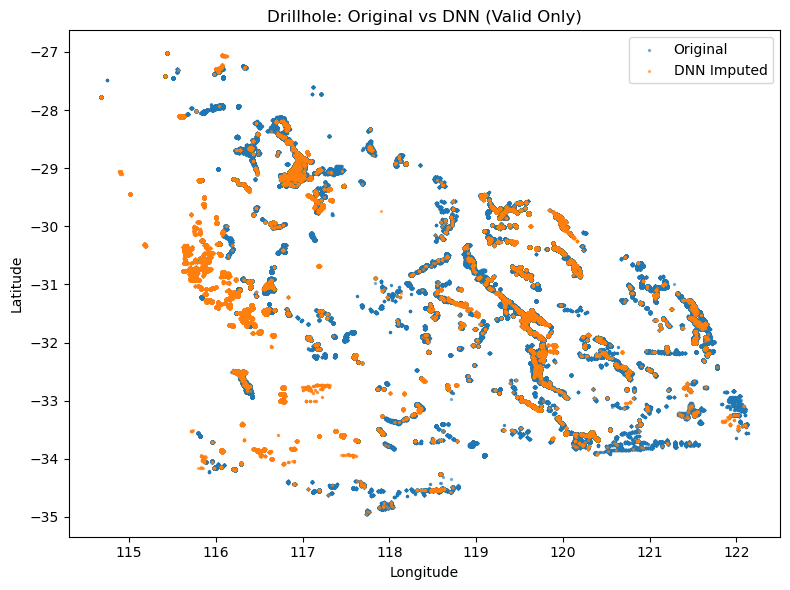

Saved: ..\reports\task1\part2\spatial_coverage\drillhole_coverage.png


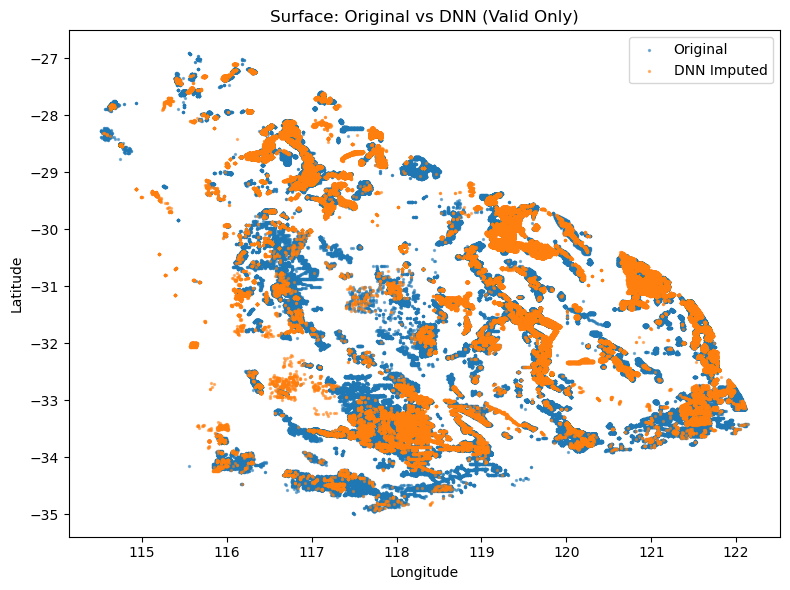

Saved: ..\reports\task1\part2\spatial_coverage\surface_coverage.png


In [15]:
import matplotlib.pyplot as plt
PART2_DIR = Path("../reports/task1/part2")
COVERAGE_DIR = PART2_DIR / "spatial_coverage"
COVERAGE_DIR.mkdir(parents=True, exist_ok=True)

def plot_spatial(df_o, df_d, lon_col, lat_col, title, outfile):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(df_o[lon_col], df_o[lat_col], s=2, alpha=0.5, label="Original")
    ax.scatter(df_d[lon_col], df_d[lat_col], s=2, alpha=0.5, label="DNN Imputed")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(title)
    ax.legend(loc="best")
    plt.tight_layout()
    outpath = COVERAGE_DIR / outfile
    plt.savefig(outpath, dpi=200)
    plt.show()
    print(f"Saved: {outpath}")

# Drillhole 
plot_spatial(
    df_o=df_dh_orig_valid,
    df_d=df_dh_dl_valid,
    lon_col="LONGITUDE",
    lat_col="LATITUDE",
    title="Drillhole: Original vs DNN (Valid Only)",
    outfile="drillhole_coverage.png",
)

# Surface 
plot_spatial(
    df_o=df_surf_orig_valid,
    df_d=df_surf_dl_valid,
    lon_col="DLONG",
    lat_col="DLAT",
    title="Surface: Original vs DNN (Valid Only)",
    outfile="surface_coverage.png",
)


**Interpretation**:

The DNN-imputed datasets provide additional spatial coverage, particularly in regions with limited or missing original assays.This supports the project's aim of revealing hidden exploration targets by filling analytical gaps.

## 7. Value Distribution Comparison
**Goal**:
Compare the statistical distributions of copper concentrations across the datasets.

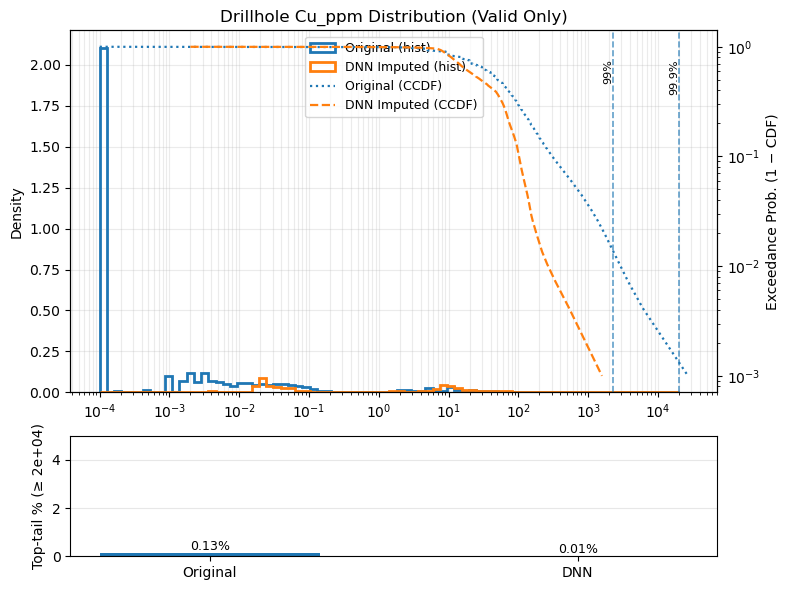

Saved: ..\reports\task1\part2\value_distribution\drillhole_cu_distribution.png


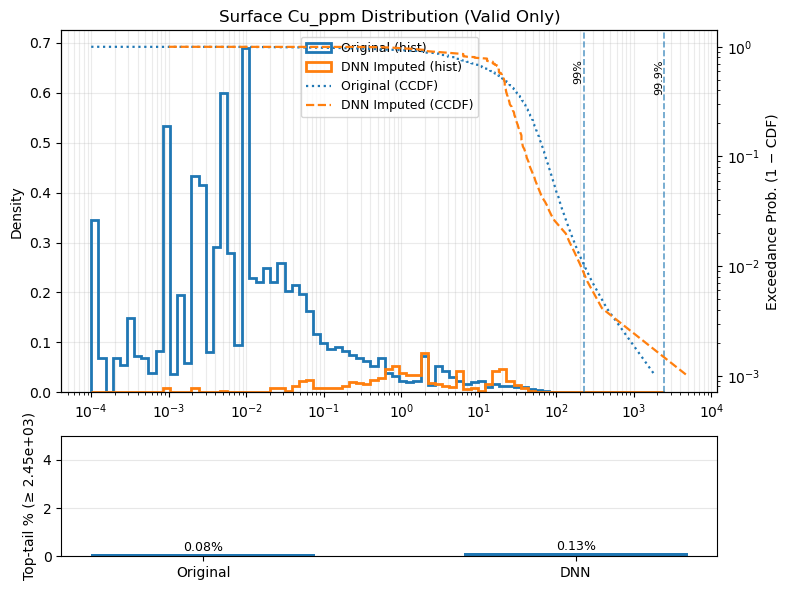

Saved: ..\reports\task1\part2\value_distribution\surface_cu_distribution.png


In [36]:
DIST_DIR  = PART2_DIR / "value_distribution"
DIST_DIR.mkdir(parents=True, exist_ok=True)


def _log_bins(x, bins=80, clip_q=0.999, floor=1e-5):
    """
    Build logarithmic bin edges between a robust low/high range.
    - low bound: max(floor, finite min)
    - high bound: clip at quantile `clip_q` to avoid a few extreme outliers
    """
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.logspace(np.log10(floor), np.log10(floor * 10), bins + 1)
    lo = max(floor, np.min(x))
    hi = np.quantile(x, clip_q)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo >= hi:
        lo, hi = floor, floor * 10
    return np.logspace(np.log10(lo), np.log10(hi), bins + 1)

def _ccdf_xy(samples, npts=300, q_max=0.999):
    """
    Compute x-y for CCDF (1 - CDF) on a quantile grid.
    - x: quantile values of `samples`
    - y: 1 - p  (exceedance probability)
    Using quantiles avoids plotting too many points and is robust on heavy tails.
    """
    s = np.asarray(samples)
    s = s[np.isfinite(s)]
    if s.size == 0:
        return np.array([np.nan]), np.array([np.nan])
    p = np.linspace(0, q_max, npts)
    x = np.quantile(s, p)
    y = 1.0 - p
    return x, y

#main plotting
def plot_distribution(
    df_o, df_d, title, outfile, col="Cu_ppm",
    bins=80, clip_q=0.999, floor=1e-5, tail_q=0.999
):
    """
    Plot log-histograms for Original vs DNN-imputed values, emphasize large values:
    - Main axis: shared log-binned histograms (density), plus CCDF on a twin y-axis (log).
    - Bottom axis: bar chart of "Top-tail %" >= combined tail threshold (quantile `tail_q`).
    """
    # Parse column to numeric and drop NaNs
    s_o_full = pd.to_numeric(df_o[col], errors="coerce").dropna().values
    s_d_full = pd.to_numeric(df_d[col], errors="coerce").dropna().values

    # Remove floor-only values from the histograms (keep them for % calculations)
    eps = 1e-12
    o_floor_mask = np.isclose(s_o_full, floor, atol=eps) | (s_o_full < floor)
    d_floor_mask = np.isclose(s_d_full, floor, atol=eps) | (s_d_full < floor)
    s_o = s_o_full[~o_floor_mask]
    s_d = s_d_full[~d_floor_mask]

    # Shared log bins for fair comparison
    edges = _log_bins(np.concatenate([s_o, s_d]) if (s_o.size + s_d.size) else np.array([floor]),
                      bins=bins, clip_q=clip_q, floor=floor)

    # Figure with two rows: main plot + tail-percentage bars
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(8, 6),
        gridspec_kw={"height_ratios": [3, 1]}
    )

    #Main: log-histograms
    handles = []
    labels  = []
    if s_o.size > 0:
        h1 = ax1.hist(s_o, bins=edges, density=True, histtype="step", linewidth=2.0, label="Original")
        handles.append(h1[2][0]); labels.append("Original (hist)")
    if s_d.size > 0:
        h2 = ax1.hist(s_d, bins=edges, density=True, histtype="step", linewidth=2.0, label="DNN Imputed")
        handles.append(h2[2][0]); labels.append("DNN Imputed (hist)")

    ax1.set_xscale("log")
    ax1.set_ylabel("Density")
    ax1.set_title(title)
    ax1.grid(which="both", axis="both", alpha=0.25)

    # Mark reference quantiles on the x-axis to highlight the upper tail
    both_full = np.concatenate([s_o_full, s_d_full])
    both_full = both_full[np.isfinite(both_full)]
    q_marks = []
    if both_full.size > 0:
        q99   = np.quantile(both_full, 0.99)
        qtail = np.quantile(both_full, tail_q)
        for qv, txt in [(q99, "99%"), (qtail, f"{int(tail_q*1000)/10:.1f}%")]:
            ax1.axvline(qv, linestyle="--", linewidth=1.2, alpha=0.7)
            ax1.text(qv, ax1.get_ylim()[1]*0.92, txt, rotation=90, va="top", ha="right", fontsize=8)
        q_marks = [q99, qtail]

    #CCDF overlay on a twin y-axis (log) to emphasize extremes ---
    ax1b = ax1.twinx()
    ax1b.set_yscale("log")
    ax1b.set_ylabel("Exceedance Prob. (1 − CDF)")
    if s_o.size > 0:
        xo, yo = _ccdf_xy(s_o, npts=320, q_max=0.999)
        lo1,   = ax1b.plot(xo, yo, linestyle=":", linewidth=1.6)
        handles.append(lo1); labels.append("Original (CCDF)")
    if s_d.size > 0:
        xd, yd = _ccdf_xy(s_d, npts=320, q_max=0.999)
        ld1,   = ax1b.plot(xd, yd, linestyle="--", linewidth=1.6)
        handles.append(ld1); labels.append("DNN Imputed (CCDF)")

    # Single legend combining both axes
    if handles:
        ax1.legend(handles, labels, loc="best", fontsize=9, frameon=True)

    #Bottom: Top-tail percentage (>= combined tail threshold)
    if both_full.size == 0:
        hi_thr = np.nan
        bars_h = [0.0, 0.0]
        o_total = d_total = 0
    else:
        hi_thr = np.quantile(both_full, tail_q)
        o_total, d_total = s_o_full.size, s_d_full.size
        o_top_n = int(np.sum(s_o_full >= hi_thr))
        d_top_n = int(np.sum(s_d_full >= hi_thr))
        bars_h  = [
            (o_top_n / o_total * 100.0) if o_total else 0.0,
            (d_top_n / d_total * 100.0) if d_total else 0.0
        ]

    bars_x = np.arange(2)
    bars = ax2.bar(bars_x, bars_h, width=0.6)
    ax2.set_xticks(bars_x, ["Original", "DNN"])
    if np.isfinite(hi_thr):
        ax2.set_ylabel(f"Top-tail % (≥ {hi_thr:.3g})")
    else:
        ax2.set_ylabel("Top-tail %")
    ax2.set_ylim(0, max(5, max(bars_h) * 1.15))
    ax2.grid(axis="y", alpha=0.3)

    # Annotate exact percentages on bars
    for rect, val in zip(bars, bars_h):
        ax2.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.02,
                 f"{val:.2f}%", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    save_path = DIST_DIR / outfile
    plt.savefig(save_path, dpi=200)
    plt.show()
    print(f"Saved: {save_path}")


# Drillhole (valid)
plot_distribution(
    df_o=df_dh_orig_valid,
    df_d=df_dh_dl_valid,
    title="Drillhole Cu_ppm Distribution (Valid Only)",
    outfile="drillhole_cu_distribution.png",
    bins=80, clip_q=0.999, floor=1e-5, tail_q=0.999
)

# Surface (valid)
plot_distribution(
    df_o=df_surf_orig_valid,
    df_d=df_surf_dl_valid,
    title="Surface Cu_ppm Distribution (Valid Only)",
    outfile="surface_cu_distribution.png",
    bins=80, clip_q=0.999, floor=1e-5, tail_q=0.999
)

**Interpretation**:

Original datasets contain a wider range of copper values and occasional outlier.
DNN-imputed values are generally lower and more tightly clustered, which may reflect conservative estimation by the model.

## 8. Advanced Distribution Analysis

In [17]:
ADV_DIR   = PART2_DIR / "advanced_distribution"
ADV_DIR.mkdir(parents=True, exist_ok=True)

try:
    from scipy.stats import ks_2samp, gaussian_kde
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

#safely get positive series
def _positive_series(df, col="Cu_ppm"):
    """Return 1D float array of strictly-positive values (required for log10)."""
    s = pd.to_numeric(df[col], errors="coerce")
    s = s[np.isfinite(s) & (s > 0)]
    return s.astype(float).values

#empirical CDF
def _ecdf(y):
    """Return (x, F(x)) for empirical CDF of vector y."""
    x = np.sort(y)
    n = x.size
    F = np.arange(1, n + 1) / n
    return x, F

#KDE on linear or log domain
def _kde_curve(y, grid=None):
    """Return (grid, density) for a gaussian KDE if SciPy is available; else None."""
    if not _HAS_SCIPY or y.size == 0:
        return None, None
    kde = gaussian_kde(y)
    if grid is None:
        lo, hi = np.percentile(y, [0.5, 99.5])
        if lo == hi:
            lo, hi = y.min(), y.max() + 1e-6
        grid = np.linspace(lo, hi, 256)
    dens = kde(grid)
    return grid, dens

#quantile table
def quantile_table(name_to_arrays, q_list=(1,5,10,25,50,75,90,95,99), log10=False):
    """
    Build a tidy quantile table (rows=datasets, cols=quantiles).
    If log10=True, compute quantiles on log10 values (interpreted in log domain).
    """
    out = {}
    for name, arr in name_to_arrays.items():
        arr = np.asarray(arr)
        if arr.size == 0:
            out[name] = [np.nan]*len(q_list)
            continue
        base = np.log10(arr) if log10 else arr
        out[name] = np.percentile(base, q_list).round(6)
    tbl = pd.DataFrame(out, index=[f"P{q}" for q in q_list]).T
    return tbl

#Effect size: Cliffs delta (for non-normal)
def cliffs_delta(x, y):
    """
    Compute Cliff's delta effect size: delta in [-1,1].
    Positive -> x tends to be larger than y.
    """
    x = np.asarray(x); y = np.asarray(y)
    if x.size == 0 or y.size == 0:
        return np.nan
    #if extremely large, to keep runtime reasonable, downsample
    max_n = 200000
    if x.size > max_n:
        x = np.random.default_rng(42).choice(x, size=max_n, replace=False)
    if y.size > max_n:
        y = np.random.default_rng(42).choice(y, size=max_n, replace=False)
    #Efficient pairwise comparison via sorting + ranks would faster
    #For robustness and speed, use smaller subsample if still huge
    sub_n = 80000
    if x.size * y.size > sub_n**2:
        rng = np.random.default_rng(123)
        x = rng.choice(x, size=sub_n, replace=False)
        y = rng.choice(y, size=sub_n, replace=False)
    #Compute delta
    count = 0
    for xi in x:
        count += (xi > y).sum() - (xi < y).sum()
    delta = count / (x.size * y.size)
    return float(delta)

### 8.1 Log-Scale Histogram

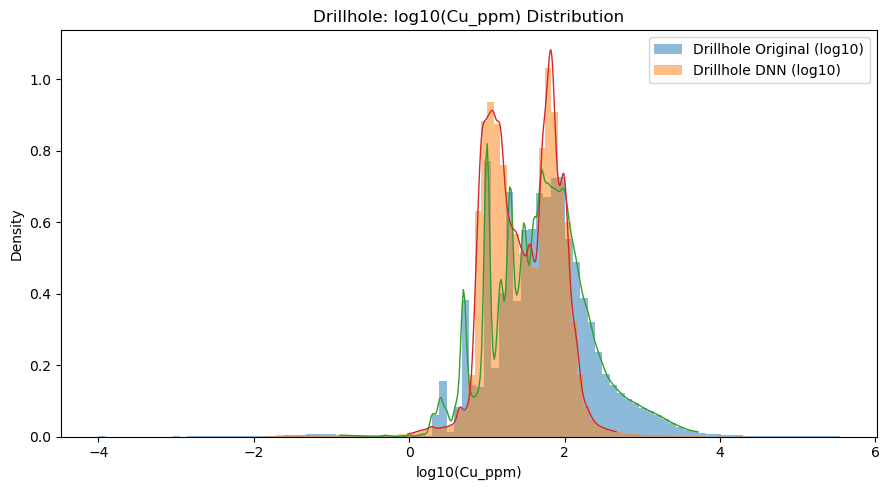

Saved: ..\reports\task1\part2\advanced_distribution\drillhole_log_hist_kde.png


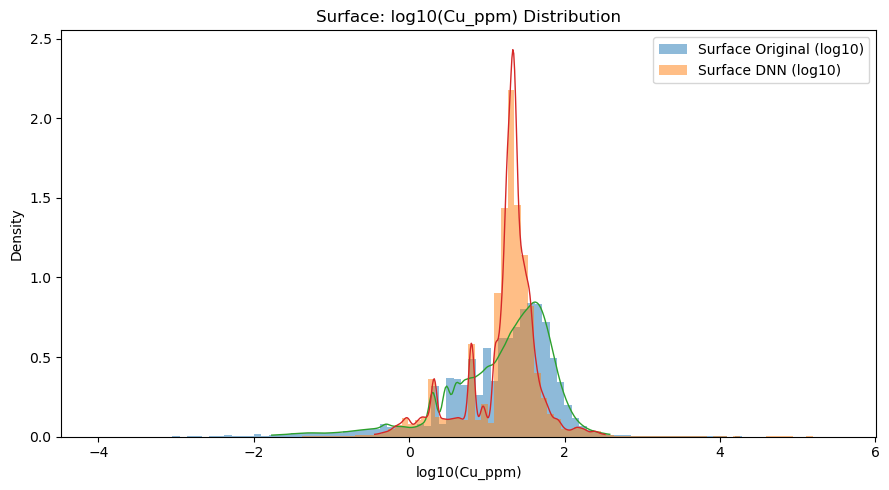

Saved: ..\reports\task1\part2\advanced_distribution\surface_log_hist_kde.png


In [18]:
# Prepare strictly positive arrays from valid datasets
dh_o = _positive_series(df_dh_orig_valid,  "Cu_ppm")
dh_d = _positive_series(df_dh_dl_valid,    "Cu_ppm")
sf_o = _positive_series(df_surf_orig_valid,"Cu_ppm")
sf_d = _positive_series(df_surf_dl_valid,  "Cu_ppm")

# Log10 transforms
dh_o_log = np.log10(dh_o); dh_d_log = np.log10(dh_d)
sf_o_log = np.log10(sf_o); sf_d_log = np.log10(sf_d)

# Drillhole plot
plt.figure(figsize=(9,5))
plt.hist(dh_o_log, bins=100, density=True, alpha=0.5, label="Drillhole Original (log10)")
plt.hist(dh_d_log, bins=100, density=True, alpha=0.5, label="Drillhole DNN (log10)")
if _HAS_SCIPY:
    gx, gy = _kde_curve(dh_o_log); 
    if gx is not None: plt.plot(gx, gy, linewidth=1)
    gx, gy = _kde_curve(dh_d_log); 
    if gx is not None: plt.plot(gx, gy, linewidth=1)
plt.xlabel("log10(Cu_ppm)")
plt.ylabel("Density")
plt.title("Drillhole: log10(Cu_ppm) Distribution")
plt.legend()
plt.tight_layout()
out_dh = ADV_DIR / "drillhole_log_hist_kde.png"
plt.savefig(out_dh, dpi=200)
plt.show()
print(f"Saved: {out_dh}")

# Surface plot
plt.figure(figsize=(9,5))
plt.hist(sf_o_log, bins=100, density=True, alpha=0.5, label="Surface Original (log10)")
plt.hist(sf_d_log, bins=100, density=True, alpha=0.5, label="Surface DNN (log10)")
if _HAS_SCIPY:
    gx, gy = _kde_curve(sf_o_log); 
    if gx is not None: plt.plot(gx, gy, linewidth=1)
    gx, gy = _kde_curve(sf_d_log); 
    if gx is not None: plt.plot(gx, gy, linewidth=1)
plt.xlabel("log10(Cu_ppm)")
plt.ylabel("Density")
plt.title("Surface: log10(Cu_ppm) Distribution")
plt.legend()
plt.tight_layout()
out_sf = ADV_DIR / "surface_log_hist_kde.png"
plt.savefig(out_sf, dpi=200)
plt.show()
print(f"Saved: {out_sf}")

### 8.2 Log‑scale distributions

Compare cumulative distributions in log10 scale (empirical CDF).

C:\Users\Administrator\AppData\Local\Temp\ipykernel_46248\4013135509.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(drill_ecdf_path, dpi=300, bbox_inches="tight")
F:\ANACONDA3\envs\geo-cu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


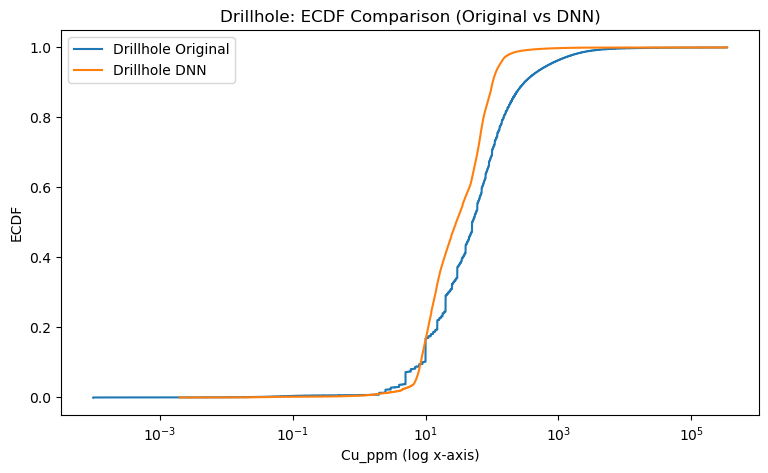

Saved: ..\reports\task1\part2\advanced_distribution\ecdf_drillhole_log.png


C:\Users\Administrator\AppData\Local\Temp\ipykernel_46248\4013135509.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(surface_ecdf_path, dpi=300, bbox_inches="tight")


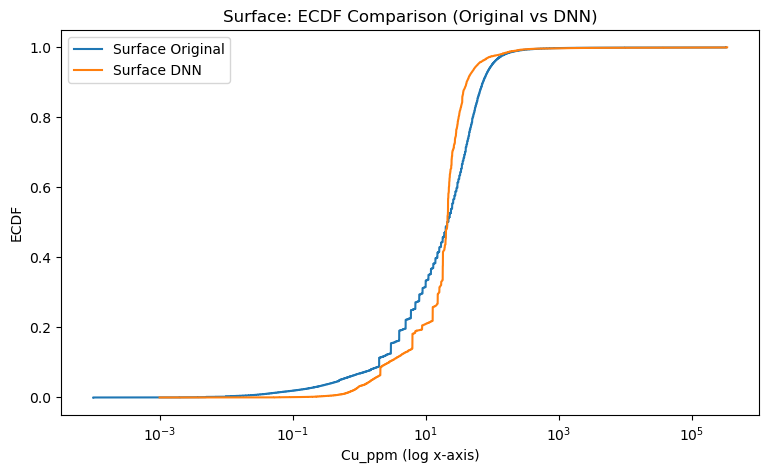

Saved: ..\reports\task1\part2\advanced_distribution\ecdf_surface_log.png


In [19]:
# Drillhole
x1, F1 = _ecdf(dh_o)
x2, F2 = _ecdf(dh_d)
plt.figure(figsize=(9,5))
plt.plot(x1, F1, drawstyle="steps-post", label="Drillhole Original")
plt.plot(x2, F2, drawstyle="steps-post", label="Drillhole DNN")
plt.xscale("log")
plt.xlabel("Cu_ppm (log x-axis)")
plt.ylabel("ECDF")
plt.title("Drillhole: ECDF Comparison (Original vs DNN)")
plt.legend()
drill_ecdf_path = ADV_DIR / "ecdf_drillhole_log.png"
plt.savefig(drill_ecdf_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: {drill_ecdf_path}")

# Surface
x1, F1 = _ecdf(sf_o)
x2, F2 = _ecdf(sf_d)
plt.figure(figsize=(9,5))
plt.plot(x1, F1, drawstyle="steps-post", label="Surface Original")
plt.plot(x2, F2, drawstyle="steps-post", label="Surface DNN")
plt.xscale("log")
plt.xlabel("Cu_ppm (log x-axis)")
plt.ylabel("ECDF")
plt.title("Surface: ECDF Comparison (Original vs DNN)")
plt.legend()
surface_ecdf_path = ADV_DIR / "ecdf_surface_log.png"
plt.savefig(surface_ecdf_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: {surface_ecdf_path}")

### 8.3 Quantile comparison tables (linear & log)

In [20]:
dh_quant_lin = quantile_table({"Drillhole Original": dh_o, "Drillhole DNN": dh_d}, log10=False)
dh_quant_log = quantile_table({"Drillhole Original": dh_o, "Drillhole DNN": dh_d}, log10=True)
sf_quant_lin = quantile_table({"Surface Original": sf_o, "Surface DNN": sf_d},   log10=False)
sf_quant_log = quantile_table({"Surface Original": sf_o, "Surface DNN": sf_d},   log10=True)

dh_quant_lin_path = ADV_DIR / "quantiles_drillhole_linear.csv"
dh_quant_log_path = ADV_DIR / "quantiles_drillhole_log.csv"
sf_quant_lin_path = ADV_DIR / "quantiles_surface_linear.csv"
sf_quant_log_path = ADV_DIR / "quantiles_surface_log.csv"

dh_quant_lin.to_csv(dh_quant_lin_path, index=True)
dh_quant_log.to_csv(dh_quant_log_path, index=True)
sf_quant_lin.to_csv(sf_quant_lin_path, index=True)
sf_quant_log.to_csv(sf_quant_log_path, index=True)

print("Drillhole quantiles (linear):");  display(dh_quant_lin); print(f"Saved: {dh_quant_lin_path}")
print("\nDrillhole quantiles (log10):");  display(dh_quant_log); print(f"Saved: {dh_quant_log_path}")
print("\nSurface quantiles (linear):");   display(sf_quant_lin); print(f"Saved: {sf_quant_lin_path}")
print("\nSurface quantiles (log10):");   display(sf_quant_log); print(f"Saved: {sf_quant_log_path}")

Drillhole quantiles (linear):


,P1,P5,P10,P25,P50,P75,P90,P95,P99
Drillhole Original,2.000,5.000,9.000,20.000,50.000,120.000,307.000,708.0000,2906.000
Drillhole DNN,1.933,7.162,8.475,12.391,28.829,67.068,102.221,129.6138,267.032


Saved: ..\reports\task1\part2\advanced_distribution\quantiles_drillhole_linear.csv

Drillhole quantiles (log10):


,P1,P5,P10,P25,P50,P75,P90,P95,P99
Drillhole Original,0.301030,0.698970,0.954243,1.301030,1.69897,2.079181,2.487138,2.850033,3.463296
Drillhole DNN,0.286232,0.855034,0.928140,1.093106,1.45983,1.826515,2.009540,2.112651,2.426563


Saved: ..\reports\task1\part2\advanced_distribution\quantiles_drillhole_log.csv

Surface quantiles (linear):


,P1,P5,P10,P25,P50,P75,P90,P95,P99
Surface Original,0.039,0.510,2.000,6.300,21.000,45.00,72.000,99.0000,231.00000
Surface DNN,0.576,1.558,2.791,12.792,21.107,28.52,41.315,59.9265,209.80345


Saved: ..\reports\task1\part2\advanced_distribution\quantiles_surface_linear.csv

Surface quantiles (log10):


,P1,P5,P10,P25,P50,P75,P90,P95,P99
Surface Original,-1.408935,-0.292430,0.30103,0.799341,1.322219,1.653213,1.857332,1.995635,2.363612
Surface DNN,-0.239578,0.192567,0.44576,1.106938,1.324427,1.455150,1.616108,1.777619,2.321813


Saved: ..\reports\task1\part2\advanced_distribution\quantiles_surface_log.csv


### 8.4 Distribution difference tests (KS & Cliff’s delta)

In [21]:
if _HAS_SCIPY:
    ks_dh = ks_2samp(dh_o, dh_d, alternative="two-sided", mode="auto")
    ks_sf = ks_2samp(sf_o, sf_d, alternative="two-sided", mode="auto")
else:
    ks_dh = ks_sf = None

delta_dh = cliffs_delta(dh_o, dh_d)
delta_sf = cliffs_delta(sf_o, sf_d)

stat_summary = pd.DataFrame(
    [
        {
            "Pair": "Drillhole (Orig vs DNN)",
            "KS_stat": (float(ks_dh.statistic) if ks_dh else np.nan),
            "KS_pvalue": (float(ks_dh.pvalue) if ks_dh else np.nan),
            "Cliffs_delta": float(delta_dh),
            "N_Orig": int(dh_o.size), "N_DNN": int(dh_d.size),
        },
        {
            "Pair": "Surface (Orig vs DNN)",
            "KS_stat": (float(ks_sf.statistic) if ks_sf else np.nan),
            "KS_pvalue": (float(ks_sf.pvalue) if ks_sf else np.nan),
            "Cliffs_delta": float(delta_sf),
            "N_Orig": int(sf_o.size), "N_DNN": int(sf_d.size),
        },
    ],
    columns=["Pair","KS_stat","KS_pvalue","Cliffs_delta","N_Orig","N_DNN"]
)

out_tests = ADV_DIR / "distribution_tests_summary.csv"
stat_summary.to_csv(out_tests, index=False)
display(stat_summary)
print(f"Saved: {out_tests}")

,Pair,KS_stat,KS_pvalue,Cliffs_delta,N_Orig,N_DNN
0,Drillhole (Orig vs DNN),0.199758,0.0,0.227412,2466130,920225
1,Surface (Orig vs DNN),0.199225,0.0,0.046137,981318,544886


Saved: ..\reports\task1\part2\advanced_distribution\distribution_tests_summary.csv


In [22]:
# This step saves each cleaned DataFrame to CSV for downstream analysis,
# ensuring that the final EDA output includes not just statistics and
# diagnostic tables, but also the four cleaned datasets ready for use.
CLEAN_DIR = Path("../reports/task1/cleaned")
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

df_dh_orig_valid.to_csv(CLEAN_DIR / "drillhole_original_clean.csv", index=False)
df_dh_dl_valid.to_csv(CLEAN_DIR / "drillhole_dnn_clean.csv", index=False)
df_surf_orig_valid.to_csv(CLEAN_DIR / "surface_original_clean.csv", index=False)
df_surf_dl_valid.to_csv(CLEAN_DIR / "surface_dnn_clean.csv", index=False)

print("Saved 4 cleaned datasets to:", CLEAN_DIR)

Saved 4 cleaned datasets to: ..\reports\task1\cleaned


### Overall Conclusion 

Through exploratory analysis of drillhole and surface copper content data (original and DNN-imputed), we reached the following key insight:

Distribution Characteristics: The DNN-imputed data is notably more centralized, with fewer extreme high values, reflect a more conservative estimation pattern. The original data shows greater variability and occasional extreme peak.

Improved Spatial Coverage: DNN imputation effectively fills spatial gaps present in the original datasets, enhances coverage for subsequent spatial analysis and potential anomaly detection.

Distribution Difference Significance: The log10-transformed distribution, ECDF, quantile comparisons, and KS tests from quantitatively confirmed distributional difference between DNN and original dataset, with drillhole data difference being more pronounced than surface data.

Consistency: The quantitative results from advanced analysis are consistent with the qualitative observations with previous one, but provide stronger numerical evidence and statistical validation.


# Appendix - Validation Strategy & Data Cleaning and Filtering Functions


### Scope
In overlap regions, original Cu_ppm is unreliable and cannot be used for residual analysis or ground-truth validation.



### Problem Statement
Paul clarified that Original Cu_ppm values are unreliable within overlap regions. In this EDA we will retain Original observations in overlap, but explicitly mark them as unreliable_overlap for downstream safety (soft removal). We will not compute residuals in overlap. Instead, we will:

keep DNN samples as-is in overlap;

keep Original samples in overlap but flag them as unreliable;

continue reporting overlap coverage and audit lists;

focus any comparative assessment on non-overlap areas (no residuals in overlap).




In [23]:
# Part 3 outputs
PART3_DIR = Path("../reports/task1/part3")
PART3_DIR.mkdir(parents=True, exist_ok=True)

IGNORE = ("SAMPLEID", "Cu_ppm", "SPURIOUS")

def compare_dataset_overlap(df_dl, df_ori, ignore=IGNORE):
    # base names present on both sides
    overlap_all  = [c for c in df_dl.columns if c in df_ori.columns]
    compare_base = [c for c in overlap_all if c not in ignore]

    # rename ALL overlapping columns so we always have *_dl / *_ori
    dl_ren  = df_dl.rename(columns={c: f"{c}_dl"  for c in overlap_all})
    ori_ren = df_ori.rename(columns={c: f"{c}_ori" for c in overlap_all})

    left_keys  = [f"{c}_dl"  for c in compare_base]
    right_keys = [f"{c}_ori" for c in compare_base]

    # A) record-level matches (keeps all duplicates)
    matched_records = dl_ren.merge(ori_ren, left_on=left_keys, right_on=right_keys, how="inner")
    n_records = len(matched_records)
    p_records = (n_records / len(df_dl) * 100) if len(df_dl) else 0.0

    # B) unique-key matches → 1 row per unique key, same columns as A)
    dl_keys  = df_dl[compare_base].drop_duplicates()
    ori_keys = df_ori[compare_base].drop_duplicates()
    keys     = dl_keys.merge(ori_keys, on=compare_base, how="inner")           # unique keys only

    # pick the first matching row from each side per key
    dl_pick = (dl_ren.merge(keys.rename(columns={c: f"{c}_dl" for c in compare_base}),
                            on=left_keys, how="inner")
                     .sort_values(left_keys)
                     .drop_duplicates(subset=left_keys, keep="first"))
    ori_pick = (ori_ren.merge(keys.rename(columns={c: f"{c}_ori" for c in compare_base}),
                              on=right_keys, how="inner")
                       .sort_values(right_keys)
                       .drop_duplicates(subset=right_keys, keep="first"))

    matched_unique = dl_pick.merge(ori_pick, left_on=left_keys, right_on=right_keys, how="inner")
    n_unique = len(keys)
    p_unique = (n_unique / len(dl_keys) * 100) if len(dl_keys) else 0.0

    return {
        "compare_cols": compare_base,
        "record_match_n": n_records,
        "record_match_pct": p_records,
        "matched_records_df": matched_records,
        "unique_match_n": n_unique,
        "unique_match_pct": p_unique,
        "matched_unique_df": matched_unique,   # SAME COLUMNS as matched_records_df
        "dl_total": len(df_dl),
        "dl_unique_total": len(dl_keys),
    }


# Append-only utility
def mark_overlap_flags(df_dl: pd.DataFrame,
                       df_ori: pd.DataFrame,
                       stats: dict) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Soft removal policy:
      - Keep Original samples in overlap but mark them as unreliable.
      - Keep DNN samples in overlap (no residuals computed).
    Uses keys from compare_dataset_overlap(..):
      - stats["compare_cols"]: list of key columns
      - stats["matched_unique_df"]: joined df with *_dl / *_ori suffixes for overlap unique keys
    """
    key_cols = stats["compare_cols"]

    # Build (unique) overlap keys from the matched_unique_df on the Original side
    #   Example: if key_cols = ["LONGITUDE","LATITUDE","FROMDEPTH","TODEPTH","SAMPLETYPE"]
    #   we select [f"{c}_ori" for c in key_cols], then rename back to base names.
    uni = stats["matched_unique_df"]
    ori_key_cols = [f"{c}_ori" for c in key_cols if f"{c}_ori" in uni.columns]
    if not ori_key_cols:
        # If keys are not available (unlikely), fall back to record-level matches
        uni = stats["matched_records_df"]
        ori_key_cols = [f"{c}_ori" for c in key_cols if f"{c}_ori" in uni.columns]

    overlap_keys = uni[ori_key_cols].drop_duplicates().copy()
    overlap_keys.columns = key_cols  # remove "_ori" suffix back to base names

    # Flag Original: True if in overlap keys, set reliability to "unreliable_overlap"
    ori_merge = df_ori.merge(overlap_keys, on=key_cols, how="left", indicator=True)
    df_ori = df_ori.copy()
    df_ori["overlap_flag"] = (ori_merge["_merge"] == "both")
    df_ori["reliability"]  = df_ori["overlap_flag"].map({True: "unreliable_overlap"}).fillna("reliable")

    # Flag DNN: True if in overlap keys; reliability stays "reliable" (or a separate label if needed)
    dl_merge = df_dl.merge(overlap_keys, on=key_cols, how="left", indicator=True)
    df_dl = df_dl.copy()
    df_dl["overlap_flag"] = (dl_merge["_merge"] == "both")
    # Optional: annotate DNN reliability in overlap explicitly
    df_dl["reliability"]  = df_dl["overlap_flag"].map({True: "ok_overlap"}).fillna("reliable")

    return df_dl, df_ori

def _expand_sort_cols(cols, df_cols):
    out = []
    for c in (cols or []):
        for cand in (f"{c}_dl", f"{c}_ori", c):
            if cand in df_cols:
                out.append(cand); break
    return out

def save_outputs(stats, base_name, sort_cols=None, head_n=5):
    rec_df = stats["matched_records_df"].copy()
    uni_df = stats["matched_unique_df"].copy()
    if sort_cols:
        rec_df = rec_df.sort_values(_expand_sort_cols(sort_cols, rec_df.columns))
        uni_df = uni_df.sort_values(_expand_sort_cols(sort_cols, uni_df.columns))

    p_rec = PART3_DIR / f"{base_name}_matched_records.csv"
    p_uni = PART3_DIR / f"{base_name}_matched_unique_records.csv"
    rec_df.to_csv(p_rec, index=False)
    uni_df.to_csv(p_uni, index=False)

    print(f"{base_name} — record_match_rate: {stats['record_match_n']} / {stats['dl_total']} ({stats['record_match_pct']:.2f}%)")
    print(f"{base_name} — unique_match_rate: {stats['unique_match_n']} / {stats['dl_unique_total']} ({stats['unique_match_pct']:.2f}%)")
    print(f"Saved: {p_rec}\nSaved: {p_uni}")

    display(rec_df.head(head_n))
    display(uni_df.head(head_n))

## Surface Datasets

In overlap areas, we keep only DNN samples and drop Original. The tables/figures below report coverage statistics and audit lists (keys and dropped Original samples), without residuals.

In [24]:
# Surface — RAW
surf_raw_stats = compare_dataset_overlap(df_surf_dl, df_surf_orig, ignore=IGNORE)
save_outputs(surf_raw_stats, "surface_raw",
             sort_cols=["DLONG","DLAT","SAMPLETYPE"], head_n=5)

# Surface — VALID
surf_valid_stats = compare_dataset_overlap(df_surf_dl_valid, df_surf_orig_valid, ignore=IGNORE)
save_outputs(surf_valid_stats, "surface_valid",
             sort_cols=["DLONG","DLAT","SAMPLETYPE"], head_n=5)



# Use the VALID comparison stats if you have both RAW and VALID; otherwise use the available one.
# Example below assumes you computed: surf_valid_stats = compare_dataset_overlap(df_surf_dl_valid, df_surf_orig_valid, ignore=IGNORE)

try:
    stats_for_flags = surf_valid_stats  # preferred
except NameError:
    stats_for_flags = surf_raw_stats    # fallback if only RAW available

# Key columns for Surface must match your compare_cols (usually DLONG, DLAT, SAMPLETYPE)
df_surf_dl_flagged, df_surf_orig_flagged = mark_overlap_flags(
    df_dl=df_surf_dl_valid,         # or df_surf_dl if you're flagging RAW
    df_ori=df_surf_orig_valid,      # or df_surf_orig if you're flagging RAW
    stats=stats_for_flags
)

# (Optional) export flagged versions for audit / downstream safety
FLAG_DIR = PART3_DIR / "surface_flags"
FLAG_DIR.mkdir(parents=True, exist_ok=True)
df_surf_orig_flagged.to_csv(FLAG_DIR / "surface_original_flagged.csv", index=False)
df_surf_dl_flagged.to_csv(FLAG_DIR / "surface_dnn_flagged.csv", index=False)

print("[Surface] Flagged Original overlap count:",
      int(df_surf_orig_flagged["overlap_flag"].sum()))

surface_raw — record_match_rate: 47419 / 545382 (8.69%)
surface_raw — unique_match_rate: 31114 / 433366 (7.18%)
Saved: ..\reports\task1\part3\surface_raw_matched_records.csv
Saved: ..\reports\task1\part3\surface_raw_matched_unique_records.csv


,SAMPLEID_dl,DLAT_dl,DLONG_dl,SAMPLETYPE_dl,Cu_ppm_dl,SAMPLEID_ori,DLAT_ori,DLONG_ori,SAMPLETYPE_ori,Cu_ppm_ori,SPURIOUS
45611,733977,-28.518791,114.743750,SOIL,13.014,2825010,-28.518791,114.743750,SOIL,0.01,0
45528,734005,-28.518340,114.743760,SOIL,62.462,2825038,-28.518340,114.743760,SOIL,0.01,0
45569,734034,-28.517889,114.743770,SOIL,19.107,2825067,-28.517889,114.743770,SOIL,0.01,0
45454,734064,-28.517439,114.743774,SOIL,63.957,2825097,-28.517439,114.743774,SOIL,0.01,0
45495,734096,-28.516987,114.743790,SOIL,12.441,2825129,-28.516987,114.743790,SOIL,0.01,0


,SAMPLEID_dl,DLAT_dl,DLONG_dl,SAMPLETYPE_dl,Cu_ppm_dl,SAMPLEID_ori,DLAT_ori,DLONG_ori,SAMPLETYPE_ori,Cu_ppm_ori,SPURIOUS
26791,733977,-28.518791,114.743750,SOIL,13.014,2825010,-28.518791,114.743750,SOIL,0.01,0
26823,734005,-28.518340,114.743760,SOIL,62.462,2825038,-28.518340,114.743760,SOIL,0.01,0
26857,734034,-28.517889,114.743770,SOIL,19.107,2825067,-28.517889,114.743770,SOIL,0.01,0
26888,734064,-28.517439,114.743774,SOIL,63.957,2825097,-28.517439,114.743774,SOIL,0.01,0
26965,734096,-28.516987,114.743790,SOIL,12.441,2825129,-28.516987,114.743790,SOIL,0.01,0


surface_valid — record_match_rate: 46291 / 544886 (8.50%)
surface_valid — unique_match_rate: 30521 / 433148 (7.05%)
Saved: ..\reports\task1\part3\surface_valid_matched_records.csv
Saved: ..\reports\task1\part3\surface_valid_matched_unique_records.csv


,SAMPLEID_dl,DLAT_dl,DLONG_dl,SAMPLETYPE_dl,Cu_ppm_dl,SAMPLEID_ori,DLAT_ori,DLONG_ori,SAMPLETYPE_ori,Cu_ppm_ori,SPURIOUS
44630,733977,-28.518791,114.743750,SOIL,13.014,2825010,-28.518791,114.743750,SOIL,0.01,0
44558,734005,-28.518340,114.743760,SOIL,62.462,2825038,-28.518340,114.743760,SOIL,0.01,0
44599,734034,-28.517889,114.743770,SOIL,19.107,2825067,-28.517889,114.743770,SOIL,0.01,0
44484,734064,-28.517439,114.743774,SOIL,63.957,2825097,-28.517439,114.743774,SOIL,0.01,0
44525,734096,-28.516987,114.743790,SOIL,12.441,2825129,-28.516987,114.743790,SOIL,0.01,0


,SAMPLEID_dl,DLAT_dl,DLONG_dl,SAMPLETYPE_dl,Cu_ppm_dl,SAMPLEID_ori,DLAT_ori,DLONG_ori,SAMPLETYPE_ori,Cu_ppm_ori,SPURIOUS
26550,733977,-28.518791,114.743750,SOIL,13.014,2825010,-28.518791,114.743750,SOIL,0.01,0
26582,734005,-28.518340,114.743760,SOIL,62.462,2825038,-28.518340,114.743760,SOIL,0.01,0
26616,734034,-28.517889,114.743770,SOIL,19.107,2825067,-28.517889,114.743770,SOIL,0.01,0
26647,734064,-28.517439,114.743774,SOIL,63.957,2825097,-28.517439,114.743774,SOIL,0.01,0
26724,734096,-28.516987,114.743790,SOIL,12.441,2825129,-28.516987,114.743790,SOIL,0.01,0


[Surface] Flagged Original overlap count: 36938


## Drillhole Dataset

In overlap areas, we keep only DNN samples and drop Original. The tables/figures below report coverage statistics and audit lists (keys and dropped Original samples), without residuals.

In [25]:
# Drillhole — RAW
dh_raw_stats = compare_dataset_overlap(df_dh_dl, df_dh_orig, ignore=IGNORE)
save_outputs(dh_raw_stats, "drillhole_raw",
             sort_cols=["LONGITUDE","LATITUDE","FROMDEPTH","TODEPTH","SAMPLETYPE"], head_n=5)

# Drillhole — VALID
dh_valid_stats = compare_dataset_overlap(df_dh_dl_valid, df_dh_orig_valid, ignore=IGNORE)
save_outputs(dh_valid_stats, "drillhole_valid",
             sort_cols=["LONGITUDE","LATITUDE","FROMDEPTH","TODEPTH","SAMPLETYPE"], head_n=5)

# Append-only: mark overlap flags for Drillhole datasets 
try:
    stats_for_flags = dh_valid_stats  # preferred if you have VALID comparison
except NameError:
    stats_for_flags = dh_raw_stats    # fallback

df_dh_dl_flagged, df_dh_orig_flagged = mark_overlap_flags(
    df_dl=df_dh_dl_valid,        # or df_dh_dl if you're flagging RAW
    df_ori=df_dh_orig_valid,     # or df_dh_orig if you're flagging RAW
    stats=stats_for_flags
)

FLAG_DIR = PART3_DIR / "drillhole_flags"
FLAG_DIR.mkdir(parents=True, exist_ok=True)
df_dh_orig_flagged.to_csv(FLAG_DIR / "drillhole_original_flagged.csv", index=False)
df_dh_dl_flagged.to_csv(FLAG_DIR / "drillhole_dnn_flagged.csv", index=False)

print("[Drillhole] Flagged Original overlap count:",
      int(df_dh_orig_flagged["overlap_flag"].sum()))

drillhole_raw — record_match_rate: 63711 / 920576 (6.92%)
drillhole_raw — unique_match_rate: 58499 / 913229 (6.41%)
Saved: ..\reports\task1\part3\drillhole_raw_matched_records.csv
Saved: ..\reports\task1\part3\drillhole_raw_matched_unique_records.csv


,SAMPLEID_dl,LATITUDE_dl,LONGITUDE_dl,SAMPLETYPE_dl,COLLARID_dl,FROMDEPTH_dl,TODEPTH_dl,Cu_ppm_dl,SAMPLEID_ori,LATITUDE_ori,LONGITUDE_ori,SAMPLETYPE_ori,COLLARID_ori,FROMDEPTH_ori,TODEPTH_ori,Cu_ppm_ori,SPURIOUS
49892,82917477,-30.321163,115.182976,DRILLAC,3731035,0.0,14.0,8.186,82917395,-30.321163,115.182976,DRILLAC,3731035,0.0,14.0,-9999.0,0
49890,82917478,-30.321186,115.183420,DRILLAC,3731036,0.0,13.0,8.186,82917396,-30.321186,115.183420,DRILLAC,3731036,0.0,13.0,-9999.0,0
49889,82917479,-30.321247,115.183820,DRILLAC,3731037,0.0,13.0,12.883,82917397,-30.321247,115.183820,DRILLAC,3731037,0.0,13.0,-9999.0,0
49893,82917480,-30.321140,115.184265,DRILLAC,3731034,0.0,9.0,12.883,82917398,-30.321140,115.184265,DRILLAC,3731034,0.0,9.0,-9999.0,0
49894,82917424,-30.332937,115.184610,DRILLAC,3731008,0.0,8.0,18.892,82917330,-30.332937,115.184610,DRILLAC,3731008,0.0,8.0,-9999.0,0


,SAMPLEID_dl,LATITUDE_dl,LONGITUDE_dl,SAMPLETYPE_dl,COLLARID_dl,FROMDEPTH_dl,TODEPTH_dl,Cu_ppm_dl,SAMPLEID_ori,LATITUDE_ori,LONGITUDE_ori,SAMPLETYPE_ori,COLLARID_ori,FROMDEPTH_ori,TODEPTH_ori,Cu_ppm_ori,SPURIOUS
42122,82917477,-30.321163,115.182976,DRILLAC,3731035,0.0,14.0,8.186,82917395,-30.321163,115.182976,DRILLAC,3731035,0.0,14.0,-9999.0,0
42120,82917478,-30.321186,115.183420,DRILLAC,3731036,0.0,13.0,8.186,82917396,-30.321186,115.183420,DRILLAC,3731036,0.0,13.0,-9999.0,0
42119,82917479,-30.321247,115.183820,DRILLAC,3731037,0.0,13.0,12.883,82917397,-30.321247,115.183820,DRILLAC,3731037,0.0,13.0,-9999.0,0
42123,82917480,-30.321140,115.184265,DRILLAC,3731034,0.0,9.0,12.883,82917398,-30.321140,115.184265,DRILLAC,3731034,0.0,9.0,-9999.0,0
42061,82917424,-30.332937,115.184610,DRILLAC,3731008,0.0,8.0,18.892,82917330,-30.332937,115.184610,DRILLAC,3731008,0.0,8.0,-9999.0,0


drillhole_valid — record_match_rate: 47745 / 920225 (5.19%)
drillhole_valid — unique_match_rate: 45780 / 912886 (5.01%)
Saved: ..\reports\task1\part3\drillhole_valid_matched_records.csv
Saved: ..\reports\task1\part3\drillhole_valid_matched_unique_records.csv


,SAMPLEID_dl,LATITUDE_dl,LONGITUDE_dl,SAMPLETYPE_dl,COLLARID_dl,FROMDEPTH_dl,TODEPTH_dl,Cu_ppm_dl,SAMPLEID_ori,LATITUDE_ori,LONGITUDE_ori,SAMPLETYPE_ori,COLLARID_ori,FROMDEPTH_ori,TODEPTH_ori,Cu_ppm_ori,SPURIOUS
6999,89325559,-27.418915,115.41368,DRILLRC,3945874,31.0,32.0,59.017,89323736,-27.418915,115.41368,DRILLRC,3945874,31.0,32.0,243.0,0
45921,88647673,-27.418915,115.41368,DRILLRC,3923310,31.0,32.0,59.017,88645850,-27.418915,115.41368,DRILLRC,3923310,31.0,32.0,243.0,0
7000,88647681,-27.418915,115.41368,DRILLRC,3923310,39.0,40.0,16.608,88645851,-27.418915,115.41368,DRILLRC,3923310,39.0,40.0,90.0,0
45920,89325567,-27.418915,115.41368,DRILLRC,3945874,39.0,40.0,16.608,89323737,-27.418915,115.41368,DRILLRC,3945874,39.0,40.0,90.0,0
6997,89325573,-27.418915,115.41368,DRILLRC,3945874,45.0,46.0,26.771,89323738,-27.418915,115.41368,DRILLRC,3945874,45.0,46.0,74.0,0


,SAMPLEID_dl,LATITUDE_dl,LONGITUDE_dl,SAMPLETYPE_dl,COLLARID_dl,FROMDEPTH_dl,TODEPTH_dl,Cu_ppm_dl,SAMPLEID_ori,LATITUDE_ori,LONGITUDE_ori,SAMPLETYPE_ori,COLLARID_ori,FROMDEPTH_ori,TODEPTH_ori,Cu_ppm_ori,SPURIOUS
45715,88647673,-27.418915,115.41368,DRILLRC,3923310,31.0,32.0,59.017,88645850,-27.418915,115.41368,DRILLRC,3923310,31.0,32.0,243.0,0
45718,89325559,-27.418915,115.41368,DRILLRC,3945874,31.0,32.0,59.017,89323736,-27.418915,115.41368,DRILLRC,3945874,31.0,32.0,243.0,0
45716,88647681,-27.418915,115.41368,DRILLRC,3923310,39.0,40.0,16.608,88645851,-27.418915,115.41368,DRILLRC,3923310,39.0,40.0,90.0,0
45719,89325567,-27.418915,115.41368,DRILLRC,3945874,39.0,40.0,16.608,89323737,-27.418915,115.41368,DRILLRC,3945874,39.0,40.0,90.0,0
45717,88647687,-27.418915,115.41368,DRILLRC,3923310,45.0,46.0,26.771,88645852,-27.418915,115.41368,DRILLRC,3923310,45.0,46.0,74.0,0


[Drillhole] Flagged Original overlap count: 16986


In [26]:
# make aliases
sf_raw   = surf_raw_stats
sf_valid = surf_valid_stats
dh_raw   = dh_raw_stats
dh_valid = dh_valid_stats

# --- Summary table ---
summary = pd.DataFrame([
    {"Dataset": "Surface (RAW)",     "DL Total": sf_raw["dl_total"],     "DL Unique": sf_raw["dl_unique_total"],
     "Record Match (n)": sf_raw["record_match_n"], "Record Match (%)": round(sf_raw["record_match_pct"], 2),
     "Unique Match (n)": sf_raw["unique_match_n"], "Unique Match (%)": round(sf_raw["unique_match_pct"], 2)},
    {"Dataset": "Surface (VALID)",   "DL Total": sf_valid["dl_total"],   "DL Unique": sf_valid["dl_unique_total"],
     "Record Match (n)": sf_valid["record_match_n"], "Record Match (%)": round(sf_valid["record_match_pct"], 2),
     "Unique Match (n)": sf_valid["unique_match_n"], "Unique Match (%)": round(sf_valid["unique_match_pct"], 2)},
    {"Dataset": "Drillhole (RAW)",   "DL Total": dh_raw["dl_total"],     "DL Unique": dh_raw["dl_unique_total"],
     "Record Match (n)": dh_raw["record_match_n"], "Record Match (%)": round(dh_raw["record_match_pct"], 2),
     "Unique Match (n)": dh_raw["unique_match_n"], "Unique Match (%)": round(dh_raw["unique_match_pct"], 2)},
    {"Dataset": "Drillhole (VALID)", "DL Total": dh_valid["dl_total"],   "DL Unique": dh_valid["dl_unique_total"],
     "Record Match (n)": dh_valid["record_match_n"], "Record Match (%)": round(dh_valid["record_match_pct"], 2),
     "Unique Match (n)": dh_valid["unique_match_n"], "Unique Match (%)": round(dh_valid["unique_match_pct"], 2)},
])
summary_path = PART3_DIR / "overlap_summary.csv"
summary.to_csv(summary_path, index=False)
display(summary)
print(f"Summary saved: {summary_path}")

,Dataset,DL Total,DL Unique,Record Match (n),Record Match (%),Unique Match (n),Unique Match (%)
0,Surface (RAW),545382,433366,47419,8.69,31114,7.18
1,Surface (VALID),544886,433148,46291,8.50,30521,7.05
2,Drillhole (RAW),920576,913229,63711,6.92,58499,6.41
3,Drillhole (VALID),920225,912886,47745,5.19,45780,5.01


Summary saved: ..\reports\task1\part3\overlap_summary.csv


### Implications


No residuals in overlap: Original is unreliable in overlap; we keep Original records there but mark them as unreliable_overlap (soft removal) to prevent downstream misuse.

Traceability: We export flagged versions of both datasets (Surface & Drillhole) for audit; downstream consumers can hard-drop reliability == "unreliable_overlap" if needed.

Comparisons shift: Any distributional or spatial comparisons should rely on non-overlap regions (or on DNN in overlap), avoiding residuals against unreliable Original.

Key stability: Overlap identification uses the same key columns as the existing matching skeleton (no structural change), ensuring consistent and reproducible flags.

## Data Cleaning and Filtering Functions

In [27]:
def filter_valid_cu(df, col='Cu_ppm', minval=0.00001, maxval=346000):
    return df[(df[col] > minval) & (df[col] < maxval)].copy()

In [28]:

## data check
for name, df in {
    "dh_orig_valid": df_dh_orig_valid,
    "dh_dnn_valid":  df_dh_dl_valid,
    "surf_orig_val": df_surf_orig_valid,
    "surf_dnn_val":  df_surf_dl_valid,
}.items():
    s = pd.to_numeric(df["Cu_ppm"], errors="coerce")
    print(name, "min/max:", s.min(), s.max(),
          "neg_count:", (s < 0).sum(),
          "gt_346k:", (s > 346000).sum())

dh_orig_valid min/max: 0.0001 345300.0 neg_count: 0 gt_346k: 0
dh_dnn_valid min/max: 0.002 343866.1 neg_count: 0 gt_346k: 0
surf_orig_val min/max: 0.000100000005 331446.0 neg_count: 0 gt_346k: 0
surf_dnn_val min/max: 0.001 342353.94 neg_count: 0 gt_346k: 0


In [29]:

## data check2
for name, df in {
    "dh_orig_valid": df_dh_orig_valid,
    "dh_dnn_valid":  df_dh_dl_valid,
    "surf_orig_val": df_surf_orig_valid,
    "surf_dnn_val":  df_surf_dl_valid,
}.items():
    s = pd.to_numeric(df["Cu_ppm"], errors="coerce")
    floor = (s == 1e-5)
    print(name,
          "floor%=", round(floor.mean()*100, 2),
          "p95/p99/p99.9=", np.quantile(s, [0.95, 0.99, 0.999]))

dh_orig_valid floor%= 0.0 p95/p99/p99.9= [  708.  2906. 27000.]
dh_dnn_valid floor%= 0.0 p95/p99/p99.9= [ 129.6138    267.032    1579.683488]
surf_orig_val floor%= 0.0 p95/p99/p99.9= [  99.  231. 1900.]
surf_dnn_val floor%= 0.0 p95/p99/p99.9= [  59.9265    209.80345  4945.046205]
